#### Student Name: Zheng Hanming
#### Student ID: 21225621

In [37]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
#from scipy import interp
import pickle
import matplotlib.pyplot as plt
%matplotlib inline


#### Import & Observe Data

In [38]:
# https://archive.ics.uci.edu/ml/datasets/seeds
df = pd.read_csv("./seeds.csv")
df.head()


area  perimeter  compactness  length of kernel  width of kernel  \
0  15.26      14.84       0.8710             5.763            3.312   
1  14.88      14.57       0.8811             5.554            3.333   
2  14.29      14.09       0.9050             5.291            3.337   
3  13.84      13.94       0.8955             5.324            3.379   
4  16.14      14.99       0.9034             5.658            3.562   

   asymmetry coefficient  length of kernel groove  type  
0                  2.221                    5.220     1  
1                  1.018                    4.956     1  
2                  2.699                    4.825     1  
3                  2.259                    4.805     1  
4                  1.355                    5.175     1

In [39]:
df.isna().sum()

area                       0
perimeter                  0
compactness                0
length of kernel           0
width of kernel            0
asymmetry coefficient      0
length of kernel groove    0
type                       0
dtype: int64

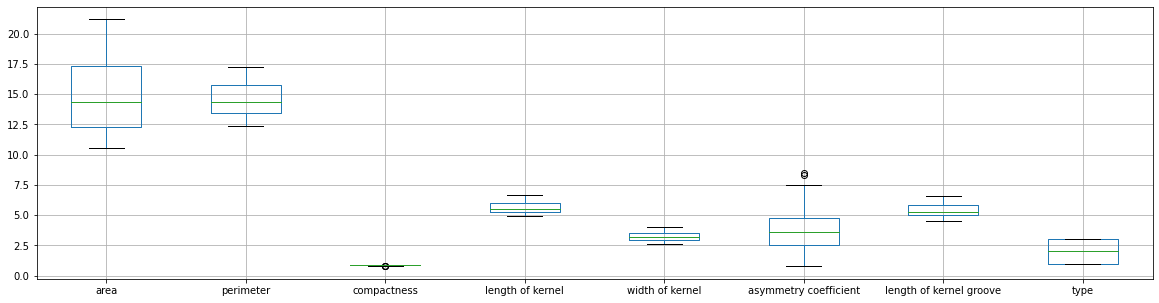

In [40]:
df.boxplot(figsize=(20, 5))
plt.show()

In [41]:
df['type'].value_counts()

1    70
2    70
3    70
Name: type, dtype: int64

#### Helpers

In [42]:
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

def train_model(classifier, param_grid, X_train, y_train):
    classifier_name = 'classifier'
    # Training Pipeline
    updated_params = {classifier_name + '__' + str(key): value for key, value in param_grid.items()}

    pipeline = Pipeline(steps=[('preprocess', preprocess), (classifier_name, classifier)])
    search = GridSearchCV(pipeline, updated_params, n_jobs=-1, cv=10, refit=True)
    # The parameter `refit = True` makes the GridSearchCV train an classifier on the ** whole training set ** with the best parameters found.
    # This best model can then be accessed via the `.best_estimator_` attribute of the GridSearchCV.

    search.fit(X_train, y_train)

    best = {
        'params': {key.replace('classifier__', ''): value for key, value in search.best_params_.items()},
        'model': search.best_estimator_,
        'score': search.best_score_
    }

    print("--------------------------------------------------------------------------------------")
    print(f"Best CV score({classifier.__class__.__name__}): {round(best.get('score'), 3)}")
    print(f"Best parameters({classifier.__class__.__name__}): {best.get('params')}")

    return best


#### Initialization

In [43]:
target_name = 'type'
all_features_names = [col_name for col_name in df if col_name != target_name]

mean_fpr = np.linspace(start=0, stop=1, num=100)
preprocess = make_pipeline(AddColumnNames(columns=all_features_names), StandardScaler())


In [44]:
y = df[target_name]
X = df[all_features_names]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)
# The parameter `stratify=y` ensures both classes are represented in the same proportion in both the training and the test sets.
# Note that after the split into a training and test sets, X_train and X_test are numpy arrays and no longer have column names. 
# That's why we needed the class above to put the names of columns back in the preprocessing pipeline.

#### Task 2

- Replicate the classifier training and evaluation demonstrated in the example notebook Lab 4 - Comparison of Binary Classifiers.ipynb but with the dataset seeds.csv. 
  - You will need to formulate a binary classification problem and transform the type column accordingly. 
- Summarise your conclusions (max 200 words in a markdown cell).
  

Binary classification problem formulated and justified. A clear discussion of the cost of misclassifying examples. Best classifier identified. Parameter exploration implemented successfully, presented well and summarised correctly. 


In [45]:
svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear', 'poly']
}
svm_best = train_model(svm.SVC(probability=True), svm_param_grid, X_train, y_train)

rf_param_grid = {
    'n_estimators': [10, 20, 30],
    'max_depth': [2, 4, 6, 8]
}
rf_best = train_model(RandomForestClassifier(), rf_param_grid, X_train, y_train)


--------------------------------------------------------------------------------------
Best CV score(SVC): 0.957
Best parameters(SVC): {'C': 100, 'gamma': 1, 'kernel': 'linear'}
--------------------------------------------------------------------------------------
Best CV score(RandomForestClassifier): 0.946
Best parameters(RandomForestClassifier): {'max_depth': 6, 'n_estimators': 10}


#### Task 3

- Train a third classifier (e.g., MLPClassifier, Naive Bayes, kNN) with seeds.csv add compare it to both SVM and Random Forest. Summarise your experience with exploring the parameters (max 150 words in a markdown cell).
  - A third classifier trained correctly and compared correctly to SVM and Random Forest.

In [46]:
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'leaf_size': [20, 30 ,40]
}
knn_best = train_model(KNeighborsClassifier(n_jobs=-1), knn_param_grid, X_train, y_train)


--------------------------------------------------------------------------------------
Best CV score(KNeighborsClassifier): 0.922
Best parameters(KNeighborsClassifier): {'leaf_size': 20, 'n_neighbors': 7, 'weights': 'uniform'}


#### Final Model Export

In [47]:
best_pipeline = make_pipeline(preprocess, svm.SVC(**svm_best.get('params')))
final_model = best_pipeline.fit(X, y)
pickle.dump(final_model, open('final_model.sav', 'wb'))
